In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_curve, auc, confusion_matrix
)
import warnings
warnings.filterwarnings('ignore')

# For visualizations
plt.style.use('seaborn-v0_8')
sns.set(font_scale=0.9)
plt.rcParams['figure.figsize'] = [10, 6]

In [66]:
def load_datasets():
    """
    Load all datasets (synthetic and real-world) and return them in a structured format
    
    Returns:
        tuple: (synthetic_datasets, real_datasets) where each is a dictionary of datasets
    """
    # Load synthetic datasets
    synthetic_datasets = {}
    # Define the dataset versions and data types
    versions = ['baseline', 'custom_dist', 'high_bias', 'low_bias']
    data_types = ['users', 'ads', 'impressions', 'conversions']
    
    # Load each dataset
    for version in versions:
        synthetic_datasets[version] = {}
        for data_type in data_types:
            file_path = f"tunable/synthetic_data/{version}/{data_type}.csv"
            try:
                synthetic_datasets[version][data_type] = pd.read_csv(file_path)
                print(f"Loaded {version}/{data_type}.csv: {synthetic_datasets[version][data_type].shape} rows")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    
    # Load real-world datasets
    real_datasets = {}
    try:
        fairjobs_df = pd.read_csv('fairjob.csv/criteo_fairness_dataset_2024-01-01_2024-05-20.csv')
        real_datasets['fairjobs'] = fairjobs_df
        print(f"Successfully loaded FairJobs dataset: {fairjobs_df.shape} rows")
    except Exception as e:
        print(f"Error loading FairJobs dataset: {e}")
        
    try:
        meta_scrape_df = pd.read_csv('meta_scrape/final_ads_bias_dataset.csv')
        real_datasets['meta_scrape'] = meta_scrape_df
        print(f"Successfully loaded Meta Scrape dataset: {meta_scrape_df.shape} rows")
    except Exception as e:
        print(f"Error loading Meta Scrape dataset: {e}")
    
    # Print dataset summaries
    print("\nSynthetic Datasets Summary:")
    for version, dataset_dict in synthetic_datasets.items():
        print(f"\n{version.title()} Dataset:")
        for data_type, df in dataset_dict.items():
            print(f" {data_type.title()}: {df.shape}")

    print("\nReal-world datasets Summary:")
    for name, df in real_datasets.items():
        if df is not None:
            print(f" {name.title()}: {df.shape}")
    
    return synthetic_datasets, real_datasets

In [81]:
def prepare_dataset(dataset_name, real_datasets, synthetic_datasets):
    """
    Prepare dataset for analysis with proper handling of all dataset types
    
    Args:
        dataset_name (str): Name of the dataset to prepare
        real_datasets (dict): Dictionary of real-world datasets
        synthetic_datasets (dict): Dictionary of synthetic datasets
        
    Returns:
        tuple: (X_train, X_test, y_train, y_test, data_info) for model training
    """
    print(f"\nPreparing dataset: {dataset_name}")
    
    if dataset_name == 'fairjobs':
        # Process FairJobs dataset
        if real_datasets is None or 'fairjobs' not in real_datasets:
            print("FairJobs dataset not found")
            return None, None, None, None, None
            
        df = real_datasets['fairjobs']
        features = ['protected_attribute', 'senior', 'displayrandom', 'rank']
        numerical_features = [f'num{i}' for i in range(16, 26)]
        categorical_features = ['cat0', 'cat1', 'cat2']
        all_features = features + numerical_features + categorical_features
        
        # Create X and y
        X = df[all_features].copy()
        
        # Make sure categorical features are properly encoded
        for col in categorical_features:
            if col in X.columns:
                # Convert to category and then to numeric codes
                X[col] = pd.Categorical(X[col]).codes
        
        y = df['click']
        protected_attr = 'protected_attribute'
        
    else:
        # Handle synthetic datasets
        if synthetic_datasets is None or dataset_name not in synthetic_datasets:
            print(f"Synthetic dataset {dataset_name} not found")
            return None, None, None, None, None
            
        dataset = synthetic_datasets[dataset_name]
        users_df = dataset['users']
        impressions_df = dataset['impressions']
        
        # Determine click column
        click_col = 'clicked' if 'clicked' in impressions_df.columns else 'click'
        
        # Merge dataframes
        merged_df = pd.merge(
            impressions_df,
            users_df,
            on='user_id',
            how='left'
        )
        
        # Select features
        categorical_features = ['gender', 'ethnicity', 'socioeconomic_status', 'device', 'platform']
        categorical_features = [f for f in categorical_features if f in merged_df.columns]
        
        numerical_features = [col for col in merged_df.columns
                           if (col.startswith('interest_') or col.startswith('browsing_')) 
                           and col in merged_df.columns][:5]
        
        features = categorical_features + numerical_features
        
        # Create X and y
        X = merged_df[features].copy()
        
        # Handle protected attribute (gender)
        if 'gender' in X.columns:
            # Create gender_binary feature
            X['gender_binary'] = X['gender'].map({'Male': 1, 'Female': 0})
            if 'Non-binary' in X['gender'].unique():
                X.loc[X['gender'] == 'Non-binary', 'gender_binary'] = 2
                
            # Filter to binary groups for simplicity if needed
            binary_mask = X['gender_binary'].isin([0, 1])
            X = X[binary_mask]
            y = merged_df.loc[binary_mask, click_col]
            protected_attr = 'gender_binary'
            
            # Drop the original gender column to avoid conversion errors
            X = X.drop(columns=['gender'])
            
            # Update categorical features list
            categorical_features.remove('gender')
        else:
            print("No protected attribute found")
            return None, None, None, None, None
        
        # Encode other categorical features
        for col in categorical_features:
            if col in X.columns:
                # Convert to category and then to numeric codes
                X[col] = pd.Categorical(X[col]).codes
        
        y = y.astype(int)  # Ensure target is int
    
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Create data info dictionary
    data_info = {
        'dataset_name': dataset_name,
        'numerical_features': numerical_features,
        'categorical_features': categorical_features,
        'protected_attribute': protected_attr,
        'positive_rate': y.mean()
    }
    
    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
    print(f"Positive rate: {y.mean():.4f}")
    
    return X_train, X_test, y_train, y_test, data_info



In [68]:

def calculate_fairness_metrics(y_true, y_pred, protected_values, method_name="Baseline", y_prob=None):
    """
    Calculate comprehensive fairness metrics
    
    Args:
        y_true (array): Ground truth labels
        y_pred (array): Predicted labels
        protected_values (array): Protected attribute values
        method_name (str): Name of the method being evaluated
        y_prob (array, optional): Predicted probabilities for ROC analysis
        
    Returns:
        dict: Dictionary of fairness metrics
    """
    # Get unique groups
    unique_groups = np.unique(protected_values)
    
    # Initialize metrics dictionary
    metrics = {'method': method_name}
    
    # Calculate metrics for each group
    group_metrics = {}
    for group in unique_groups:
        group_mask = (protected_values == group)
        if sum(group_mask) == 0:
            continue
            
        # Selection rate (proportion of positive predictions)
        selection_rate = np.mean(y_pred[group_mask])
        
        # Performance metrics
        accuracy = accuracy_score(y_true[group_mask], y_pred[group_mask])
        
        # True Positive Rate (recall for positive class)
        pos_mask = (y_true[group_mask] == 1)
        if sum(pos_mask) > 0:
            tpr = np.mean(y_pred[group_mask][pos_mask])
        else:
            tpr = 0
            
        # False Positive Rate
        neg_mask = (y_true[group_mask] == 0)
        if sum(neg_mask) > 0:
            fpr = np.mean(y_pred[group_mask][neg_mask])
        else:
            fpr = 0
            
        # Store metrics for this group
        group_metrics[group] = {
            'selection_rate': selection_rate,
            'accuracy': accuracy,
            'tpr': tpr,
            'fpr': fpr
        }
        
        # Store in main metrics
        metrics[f'selection_rate_{group}'] = selection_rate
        metrics[f'accuracy_{group}'] = accuracy
        metrics[f'tpr_{group}'] = tpr
        metrics[f'fpr_{group}'] = fpr
    
    # Calculate fairness metrics
    if len(group_metrics) >= 2:
        # Statistical parity difference (difference in selection rates)
        selection_rates = [m['selection_rate'] for m in group_metrics.values()]
        metrics['statistical_parity_difference'] = max(selection_rates) - min(selection_rates)
        
        # Disparate impact ratio
        max_sr = max(selection_rates)
        min_sr = min(selection_rates)
        if max_sr > 0:
            metrics['disparate_impact_ratio'] = min_sr / max_sr
        else:
            metrics['disparate_impact_ratio'] = 1.0
            
        # Equal opportunity difference (difference in TPRs)
        tprs = [m['tpr'] for m in group_metrics.values()]
        metrics['equal_opportunity_difference'] = max(tprs) - min(tprs)
        
        # Equalized odds difference (combined difference in TPRs and FPRs)
        fprs = [m['fpr'] for m in group_metrics.values()]
        metrics['equalized_odds_difference'] = (max(tprs) - min(tprs)) + (max(fprs) - min(fprs))
    
    return metrics


In [69]:
def train_baseline_model(X_train, y_train, X_test, y_test, data_info):
    """
    Train baseline model with no debiasing
    
    Args:
        X_train, y_train: Training data
        X_test, y_test: Test data
        data_info: Dictionary with dataset information
        
    Returns:
        tuple: (model, predictions, probabilities, fairness_metrics)
    """
    print("\nTraining baseline model")
    
    # Extract protected attribute
    protected_attr = data_info['protected_attribute']
    protected_test = X_test[protected_attr].values
    
    # Train model without protected attribute
    X_train_no_prot = X_train.drop(columns=[protected_attr])
    X_test_no_prot = X_test.drop(columns=[protected_attr])
    
    # Create and train model
    model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced'
    )
    
    model.fit(X_train_no_prot, y_train)
    
    # Generate predictions
    y_pred = model.predict(X_test_no_prot)
    probas = model.predict_proba(X_test_no_prot)[:, 1]
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"Baseline model performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Calculate fairness metrics
    fairness_metrics = calculate_fairness_metrics(
        y_test, y_pred, protected_test, "Baseline", probas
    )
    
    print("\nBaseline fairness metrics:")
    for metric in ['statistical_parity_difference', 'disparate_impact_ratio', 'equal_opportunity_difference']:
        if metric in fairness_metrics:
            print(f"{metric}: {fairness_metrics[metric]:.4f}")
    
    return model, y_pred, probas, fairness_metrics

In [70]:
def train_reweighing_model(X_train, y_train, X_test, y_test, data_info):
    """
    Train model with reweighing debiasing
    
    Args:
        X_train, y_train: Training data
        X_test, y_test: Test data
        data_info: Dictionary with dataset information
        
    Returns:
        tuple: (model, predictions, probabilities, fairness_metrics, weights)
    """
    print("\nTraining model with reweighing")
    
    # Extract protected attribute
    protected_attr = data_info['protected_attribute']
    protected_train = X_train[protected_attr].values
    protected_test = X_test[protected_attr].values
    
    # Calculate instance weights
    weights = np.ones(len(X_train))
    
    # Calculate overall positive rate
    pos_rate = np.mean(y_train == 1)
    neg_rate = 1 - pos_rate
    
    # Calculate weights for each group and outcome
    for val in np.unique(protected_train):
        group_mask = (protected_train == val)
        group_size = sum(group_mask)
        
        # Skip if empty group
        if group_size == 0:
            continue
            
        # Calculate positive rate in this group
        group_pos_rate = np.mean(y_train[group_mask] == 1)
        group_neg_rate = 1 - group_pos_rate
        
        # Group proportion
        group_prop = group_size / len(y_train)
        
        # Set weights for positive examples in this group
        pos_mask = group_mask & (y_train == 1)
        if sum(pos_mask) > 0:
            weights[pos_mask] = pos_rate / (group_pos_rate * group_prop)
            
        # Set weights for negative examples in this group
        neg_mask = group_mask & (y_train == 0)
        if sum(neg_mask) > 0:
            weights[neg_mask] = neg_rate / (group_neg_rate * group_prop)
    
    # Train model without protected attribute
    X_train_no_prot = X_train.drop(columns=[protected_attr])
    X_test_no_prot = X_test.drop(columns=[protected_attr])
    
    # Create and train model with weights
    model = RandomForestClassifier(
        n_estimators=100,
        random_state=42
    )
    
    model.fit(X_train_no_prot, y_train, sample_weight=weights)
    
    # Generate predictions
    y_pred = model.predict(X_test_no_prot)
    probas = model.predict_proba(X_test_no_prot)[:, 1]
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"Reweighing model performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Calculate fairness metrics
    fairness_metrics = calculate_fairness_metrics(
        y_test, y_pred, protected_test, "Reweighing", probas
    )
    
    print("\nReweighing fairness metrics:")
    for metric in ['statistical_parity_difference', 'disparate_impact_ratio', 'equal_opportunity_difference']:
        if metric in fairness_metrics:
            print(f"{metric}: {fairness_metrics[metric]:.4f}")
    
    return model, y_pred, probas, fairness_metrics, weights

In [71]:
def apply_threshold_optimization(probas, y_test, protected_test):
    """
    Apply threshold optimization for each protected group
    
    Args:
        probas: Predicted probabilities
        y_test: True labels
        protected_test: Protected attribute values
        
    Returns:
        tuple: (optimized_predictions, thresholds, fairness_metrics)
    """
    print("\nApplying threshold optimization")
    
    # Get unique protected groups
    unique_groups = np.unique(protected_test)
    
    # Initialize predictions and thresholds
    y_pred_optimized = np.zeros_like(y_test)
    thresholds = {}
    
    # Find optimal threshold for each group
    for group in unique_groups:
        group_mask = (protected_test == group)
        
        # Skip if too few samples
        if sum(group_mask) < 10:
            thresholds[group] = 0.5
            y_pred_optimized[group_mask] = (probas[group_mask] >= 0.5).astype(int)
            continue
        
        # Get probabilities and actual values for this group
        group_probas = probas[group_mask]
        group_actual = y_test[group_mask]
        
        # Grid search for optimal threshold
        best_threshold = 0.5
        best_f1 = 0
        
        for threshold in np.linspace(0.1, 0.9, 20):
            pred = (group_probas >= threshold).astype(int)
            
            # Skip degenerate cases
            if sum(pred) == 0 or sum(pred) == len(pred):
                continue
                
            # Calculate F1 score
            f1 = f1_score(group_actual, pred, zero_division=0)
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        # Store optimal threshold
        thresholds[group] = best_threshold
        
        # Apply threshold
        y_pred_optimized[group_mask] = (probas[group_mask] >= best_threshold).astype(int)
        
        print(f"Group {group}: optimal threshold = {best_threshold:.4f}, F1 = {best_f1:.4f}")
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred_optimized)
    precision = precision_score(y_test, y_pred_optimized, zero_division=0)
    recall = recall_score(y_test, y_pred_optimized, zero_division=0)
    f1 = f1_score(y_test, y_pred_optimized, zero_division=0)
    
    print(f"Threshold-optimized performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Calculate fairness metrics
    fairness_metrics = calculate_fairness_metrics(
        y_test, y_pred_optimized, protected_test, "ThresholdOpt"
    )
    
    print("\nThreshold-optimized fairness metrics:")
    for metric in ['statistical_parity_difference', 'disparate_impact_ratio', 'equal_opportunity_difference']:
        if metric in fairness_metrics:
            print(f"{metric}: {fairness_metrics[metric]:.4f}")
    
    return y_pred_optimized, thresholds, fairness_metrics

In [72]:
def train_adversarial_debiasing_model(X_train, y_train, X_test, y_test, data_info, model_type="RF"):
    """
    Train a model with adversarial debiasing to mitigate algorithmic bias
    Uses ensemble methods and post-processing calibration for improved fairness
    
    Args:
        X_train, y_train: Training data
        X_test, y_test: Test data
        data_info: Dictionary with dataset information
        model_type: Type of model to use ("RF" or "LR")
        
    Returns:
        tuple: (model, predictions, fairness_metrics, thresholds)
    """
    print("\nTraining Model with Adversarial Debiasing")
    
    # Extract protected attribute column
    protected_attr = data_info['protected_attribute']
    if protected_attr is None or protected_attr not in X_train.columns:
        print("Protected attribute not available")
        return None, None, {}, None
    
    protected_train = X_train[protected_attr].values
    protected_test = X_test[protected_attr].values
    
    # Extract feature information
    categorical_features = [f for f in data_info['categorical_features'] 
                          if f != protected_attr and f in X_train.columns]
    numerical_features = [f for f in data_info['numerical_features'] 
                         if f in X_train.columns]
    
    # Setup preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_features)
        ],
        remainder='passthrough',
        n_jobs=-1
    )
    
    # Create adversarial versions of datasets by flipping protected attributes
    # This helps model learn to be invariant to protected attribute
    X_train_flipped = X_train.copy()
    if len(np.unique(protected_train)) == 2:
        # For binary attributes, just flip 0->1, 1->0
        X_train_flipped[protected_attr] = 1 - X_train_flipped[protected_attr]
    else:
        # For multi-class attributes, use a random other class
        for idx, val in enumerate(X_train_flipped[protected_attr]):
            other_values = [v for v in np.unique(protected_train) if v != val]
            if other_values:
                X_train_flipped.iloc[idx, X_train_flipped.columns.get_loc(protected_attr)] = np.random.choice(other_values)
    
    # Combined original and flipped data with appropriate weights
    X_train_combined = pd.concat([X_train, X_train_flipped])
    y_train_combined = np.concatenate([y_train, y_train])
    
    # Create sample weights that balance both class and protected attribute
    weights = np.ones(len(X_train_combined))
    
    # Balance classes
    class_weights = len(y_train_combined) / (2 * np.bincount(y_train_combined))
    weights[y_train_combined == 0] = class_weights[0]
    weights[y_train_combined == 1] = class_weights[1]
    
    # Balance protected attributes
    protected_combined = np.concatenate([protected_train, X_train_flipped[protected_attr].values])
    unique_protected = np.unique(protected_combined)
    protected_weights = len(protected_combined) / (len(unique_protected) * np.bincount(protected_combined.astype(int)))
    
    for val in unique_protected:
        val_idx = int(val) if isinstance(val, (int, float)) and val.is_integer() else int(val)
        weights[protected_combined == val] *= protected_weights[val_idx]
    
    # Normalize weights
    weights = weights / weights.mean()
    
    # Use ensemble of models for better robustness and fairness
    if model_type == "RF":
        # Ensemble of different random forests
        base_classifiers = [
            RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced'),
            RandomForestClassifier(n_estimators=100, max_depth=10, random_state=43, class_weight='balanced'),
            RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state=44, class_weight='balanced'),
            RandomForestClassifier(n_estimators=50, max_features='log2', random_state=45, class_weight='balanced'),
        ]
    else:
        # Ensemble of different logistic regression variants 
        base_classifiers = [
            LogisticRegression(penalty='l1', C=1.0, solver='liblinear', random_state=42, class_weight='balanced'),
            LogisticRegression(penalty='l2', C=0.5, solver='liblinear', random_state=43, class_weight='balanced'),
            LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=44, class_weight='balanced'),
            LogisticRegression(penalty=None, solver='lbfgs', random_state=45, class_weight='balanced'),
        ]
    
    # Apply preprocessing
    X_train_proc = preprocessor.fit_transform(X_train_combined)
    X_test_proc = preprocessor.transform(X_test)
    
    # Train ensemble models
    trained_models = []
    for clf in base_classifiers:
        clf.fit(X_train_proc, y_train_combined, sample_weight=weights)
        trained_models.append(clf)
    
    # Make predictions with each model
    y_pred_proba_list = [model.predict_proba(X_test_proc)[:, 1] for model in trained_models]
    y_pred_proba = np.mean(y_pred_proba_list, axis=0)
    
    # Apply calibration with group-specific thresholds
    thresholds = {}
    y_pred_calibrated = np.zeros_like(y_test, dtype=int)
    
    # Find optimal thresholds per group to maximize fairness
    unique_values = np.unique(protected_test)
    
    for val in unique_values:
        group_mask = (protected_test == val)
        if np.sum(group_mask) < 10:  # Skip if too few samples
            thresholds[val] = 0.5
            continue
        
        # Grid search for optimal threshold using multiple metrics
        best_threshold = 0.5
        best_score = -np.inf
        
        # Evaluate multiple thresholds
        for threshold in np.linspace(0.3, 0.7, 20):
            y_pred_test = (y_pred_proba[group_mask] >= threshold).astype(int)
            
            # Skip degenerate cases
            if np.all(y_pred_test == 0) or np.all(y_pred_test == 1):
                continue
                
            # Calculate combined score across metrics
            if np.sum(y_test[group_mask] == 1) > 0 and np.sum(y_test[group_mask] == 0) > 0:
                precision = precision_score(y_test[group_mask], y_pred_test, zero_division=0)
                recall = recall_score(y_test[group_mask], y_pred_test, zero_division=0)
                f1 = f1_score(y_test[group_mask], y_pred_test, zero_division=0)
                
                # Combined metric score
                combined_score = f1 * 0.6 + (precision * recall) * 0.4
                
                if combined_score > best_score:
                    best_score = combined_score
                    best_threshold = threshold
        
        thresholds[val] = best_threshold
        y_pred_calibrated[group_mask] = (y_pred_proba[group_mask] >= best_threshold).astype(int)
    
    print(f"\nCalibrated thresholds by group:")
    for val, threshold in thresholds.items():
        print(f"Group {val}: {threshold:.4f}")
    
    # Create pipeline for later use
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('ensemble', None)  # Placeholder, we'll use our custom ensemble prediction
    ])
    
    # Add the trained models to the pipeline object for later use
    model.ensemble_models = trained_models
    model.predict_proba = lambda X: np.mean([m.predict_proba(model.named_steps['preprocessor'].transform(X))[:, 1] 
                                          for m in model.ensemble_models], axis=0)
    model.predict = lambda X: (model.predict_proba(X) >= 0.5).astype(int)
    
    # Evaluate final performance
    accuracy = accuracy_score(y_test, y_pred_calibrated)
    precision = precision_score(y_test, y_pred_calibrated, zero_division=0)
    recall = recall_score(y_test, y_pred_calibrated, zero_division=0)
    f1 = f1_score(y_test, y_pred_calibrated, zero_division=0)
    
    print("\nAdversarial Debiased Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Calculate comprehensive fairness metrics
    fairness_metrics = calculate_fairness_metrics(
        y_test, y_pred_calibrated, protected_test, "AdversarialDebiasing", y_pred_proba
    )
    
    # Print key fairness metrics
    print("\nAdversarial Debiased Model Fairness Metrics:")
    for metric in ['statistical_parity_difference', 'disparate_impact_ratio', 'equal_opportunity_difference']:
        if metric in fairness_metrics:
            print(f"{metric}: {fairness_metrics[metric]:.4f}")
    
    # Return model, predictions, fairness metrics, and thresholds
    return model, y_pred_calibrated, fairness_metrics, thresholds

In [73]:
def visualize_fairness_comparison(results, dataset_name):
    """
    Visualize fairness metrics comparison
    
    Args:
        results (dict): Dictionary of fairness metrics for each method
        dataset_name (str): Name of the dataset for plot title
    """
    if not results:
        print("No results available for visualization")
        return
        
    print("\nGenerating fairness comparison visualization")
    
    # Extract metrics for each method
    method_names = []
    spd_values = []
    di_values = []
    eod_values = []
    
    for method, metrics in results.items():
        method_names.append(method)
        spd_values.append(metrics.get('statistical_parity_difference', 0))
        di_values.append(abs(metrics.get('disparate_impact_ratio', 1) - 1))  # Distance from 1
        eod_values.append(metrics.get('equal_opportunity_difference', 0))
    
    # Create figure
    plt.figure(figsize=(15, 5))
    
    # Statistical Parity Difference
    plt.subplot(1, 3, 1)
    plt.bar(method_names, spd_values, color='skyblue')
    plt.title('Statistical Parity Difference\n(Lower is Better)')
    plt.ylabel('Difference')
    plt.xticks(rotation=45)
    
    # Disparate Impact Ratio (distance from 1)
    plt.subplot(1, 3, 2)
    plt.bar(method_names, di_values, color='lightgreen')
    plt.title('Disparate Impact - Distance from 1\n(Lower is Better)')
    plt.ylabel('Distance')
    plt.xticks(rotation=45)
    
    # Equal Opportunity Difference
    plt.subplot(1, 3, 3)
    plt.bar(method_names, eod_values, color='salmon')
    plt.title('Equal Opportunity Difference\n(Lower is Better)')
    plt.ylabel('Difference')
    plt.xticks(rotation=45)
    
    plt.suptitle(f'Fairness Metrics Comparison - {dataset_name}', fontsize=16)
    plt.tight_layout()
    plt.show()


In [74]:
def run_bias_analysis(dataset_name, real_datasets, synthetic_datasets):
    """
    Run complete bias analysis pipeline for a dataset
    
    Args:
        dataset_name (str): Name of the dataset to analyze
        real_datasets (dict): Dictionary of real-world datasets
        synthetic_datasets (dict): Dictionary of synthetic datasets
        
    Returns:
        dict: Analysis results including models, predictions, and metrics
    """
    print(f"\n{'='*60}")
    print(f"BIAS ANALYSIS FOR {dataset_name.upper()}")
    print(f"{'='*60}")
    
    # Prepare data
    X_train, X_test, y_train, y_test, data_info = prepare_dataset(
        dataset_name, real_datasets, synthetic_datasets
    )
    
    if X_train is None or data_info is None:
        print(f"Could not prepare data for {dataset_name}")
        return None
    
    # Results container
    fairness_results = {}
    
    # Extract protected attribute for easier access
    protected_attr = data_info['protected_attribute']
    protected_test = X_test[protected_attr].values
    
    # 1. Baseline model
    baseline_model, baseline_pred, baseline_probas, baseline_metrics = train_baseline_model(
        X_train, y_train, X_test, y_test, data_info
    )
    fairness_results['Baseline'] = baseline_metrics
    
    # 2. Reweighing model
    reweigh_model, reweigh_pred, reweigh_probas, reweigh_metrics, weights = train_reweighing_model(
        X_train, y_train, X_test, y_test, data_info
    )
    fairness_results['Reweighing'] = reweigh_metrics
    
    # 3. Threshold optimization (on baseline probabilities)
    threshold_pred, thresholds, threshold_metrics = apply_threshold_optimization(
        baseline_probas, y_test, protected_test
    )
    fairness_results['ThresholdOpt'] = threshold_metrics
    
    # 4. Adversarial debiasing
    adv_model, adv_pred, adv_metrics, adv_thresholds = train_adversarial_debiasing_model(
        X_train, y_train, X_test, y_test, data_info
    )
    fairness_results['Adversarial'] = adv_metrics
    
    # Visualize results
    visualize_fairness_comparison(fairness_results, dataset_name)
    
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Method': list(fairness_results.keys()),
        'Statistical Parity Diff': [m.get('statistical_parity_difference', np.nan) for m in fairness_results.values()],
        'Disparate Impact Ratio': [m.get('disparate_impact_ratio', np.nan) for m in fairness_results.values()],
        'Equal Opportunity Diff': [m.get('equal_opportunity_difference', np.nan) for m in fairness_results.values()],
        'Accuracy': [
            accuracy_score(y_test, baseline_pred),
            accuracy_score(y_test, reweigh_pred),
            accuracy_score(y_test, threshold_pred),
            accuracy_score(y_test, adv_pred)
        ],
        'F1 Score': [
            f1_score(y_test, baseline_pred, zero_division=0),
            f1_score(y_test, reweigh_pred, zero_division=0),
            f1_score(y_test, threshold_pred, zero_division=0),
            f1_score(y_test, adv_pred, zero_division=0)
        ]
    })
    
    print("\nComparison of all methods:")
    print(comparison_df.round(4))
    
    return {
        'fairness_results': fairness_results,
        'comparison': comparison_df,
        'models': {
            'baseline': baseline_model,
            'reweighing': reweigh_model,
            'adversarial': adv_model
        },
        'predictions': {
            'baseline': baseline_pred,
            'reweighing': reweigh_pred,
            'threshold': threshold_pred,
            'adversarial': adv_pred
        },
        'thresholds': {
            'threshold': thresholds,
            'adversarial': adv_thresholds
        },
        'test_data': {
            'X_test': X_test,
            'y_test': y_test,
            'protected_attr': protected_attr
        }
    }


In [75]:
def run_comprehensive_analysis(dataset_names, real_datasets, synthetic_datasets):
    """
    Run complete bias analysis on multiple datasets and compare results
    
    Args:
        dataset_names (list): List of dataset names to analyze
        real_datasets (dict): Dictionary of real-world datasets
        synthetic_datasets (dict): Dictionary of synthetic datasets
        
    Returns:
        dict: Results for all datasets
    """
    results = {}
    
    for dataset_name in dataset_names:
        dataset_results = run_bias_analysis(dataset_name, real_datasets, synthetic_datasets)
        if dataset_results:
            results[dataset_name] = dataset_results
    
    # Cross-dataset comparison
    if len(results) > 1:
        print(f"\n{'='*60}")
        print("CROSS-DATASET COMPARISON")
        print(f"{'='*60}")
        
        # Create combined comparison dataframe
        all_comparisons = []
        for dataset_name, dataset_results in results.items():
            df = dataset_results['comparison'].copy()
            df['Dataset'] = dataset_name
            all_comparisons.append(df)
        
        combined_df = pd.concat(all_comparisons)
        
        print("\nCross-dataset comparison of all methods:")
        print(combined_df.round(4))
        
        # Visualize cross-dataset comparison
        plt.figure(figsize=(15, 10))
        
        # Statistical Parity
        plt.subplot(2, 2, 1)
        sns.barplot(x='Dataset', y='Statistical Parity Diff', hue='Method', data=combined_df)
        plt.title('Statistical Parity Difference\n(Lower is Better)')
        plt.ylabel('Difference')
        
        # Disparate Impact
        plt.subplot(2, 2, 2)
        sns.barplot(x='Dataset', y='Disparate Impact Ratio', hue='Method', data=combined_df)
        plt.title('Disparate Impact Ratio\n(Closer to 1 is Better)')
        plt.ylabel('Ratio')
        plt.axhline(y=1, color='g', linestyle='--', alpha=0.5)
        
        # Equal Opportunity
        plt.subplot(2, 2, 3)
        sns.barplot(x='Dataset', y='Equal Opportunity Diff', hue='Method', data=combined_df)
        plt.title('Equal Opportunity Difference\n(Lower is Better)')
        plt.ylabel('Difference')
        
        # F1 Score
        plt.subplot(2, 2, 4)
        sns.barplot(x='Dataset', y='F1 Score', hue='Method', data=combined_df)
        plt.title('F1 Score\n(Higher is Better)')
        plt.ylabel('Score')
        
        plt.suptitle('Cross-Dataset Comparison of Bias Mitigation Methods', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    return results


In [76]:

def visualize_fairness_comparison(results, dataset_name):
    """
    Visualize fairness metrics comparison
    
    Args:
        results (dict): Dictionary of fairness metrics for each method
        dataset_name (str): Name of the dataset for plot title
    """
    if not results:
        print("No results available for visualization")
        return
        
    print("\nGenerating fairness comparison visualization")
    
    # Extract metrics for each method
    method_names = []
    spd_values = []
    di_values = []
    eod_values = []
    
    for method, metrics in results.items():
        method_names.append(method)
        spd_values.append(metrics.get('statistical_parity_difference', 0))
        di_values.append(abs(metrics.get('disparate_impact_ratio', 1) - 1))  # Distance from 1
        eod_values.append(metrics.get('equal_opportunity_difference', 0))
    
    # Create figure
    plt.figure(figsize=(15, 5))
    
    # Statistical Parity Difference
    plt.subplot(1, 3, 1)
    plt.bar(method_names, spd_values, color='skyblue')
    plt.title('Statistical Parity Difference\n(Lower is Better)')
    plt.ylabel('Difference')
    plt.xticks(rotation=45)
    
    # Disparate Impact Ratio (distance from 1)
    plt.subplot(1, 3, 2)
    plt.bar(method_names, di_values, color='lightgreen')
    plt.title('Disparate Impact - Distance from 1\n(Lower is Better)')
    plt.ylabel('Distance')
    plt.xticks(rotation=45)
    
    # Equal Opportunity Difference
    plt.subplot(1, 3, 3)
    plt.bar(method_names, eod_values, color='salmon')
    plt.title('Equal Opportunity Difference\n(Lower is Better)')
    plt.ylabel('Difference')
    plt.xticks(rotation=45)
    
    plt.suptitle(f'Fairness Metrics Comparison - {dataset_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [77]:
def visualize_fairness_comparison(results, dataset_name):
    """
    Visualize fairness metrics comparison
    
    Args:
        results (dict): Dictionary of fairness metrics for each method
        dataset_name (str): Name of the dataset for plot title
    """
    if not results:
        print("No results available for visualization")
        return
        
    print("\nGenerating fairness comparison visualization")
    
    # Extract metrics for each method
    method_names = []
    spd_values = []
    di_values = []
    eod_values = []
    
    for method, metrics in results.items():
        method_names.append(method)
        spd_values.append(metrics.get('statistical_parity_difference', 0))
        di_values.append(abs(metrics.get('disparate_impact_ratio', 1) - 1))  # Distance from 1
        eod_values.append(metrics.get('equal_opportunity_difference', 0))
    
    # Create figure
    plt.figure(figsize=(15, 5))
    
    # Statistical Parity Difference
    plt.subplot(1, 3, 1)
    plt.bar(method_names, spd_values, color='skyblue')
    plt.title('Statistical Parity Difference\n(Lower is Better)')
    plt.ylabel('Difference')
    plt.xticks(rotation=45)
    
    # Disparate Impact Ratio (distance from 1)
    plt.subplot(1, 3, 2)
    plt.bar(method_names, di_values, color='lightgreen')
    plt.title('Disparate Impact - Distance from 1\n(Lower is Better)')
    plt.ylabel('Distance')
    plt.xticks(rotation=45)
    
    # Equal Opportunity Difference
    plt.subplot(1, 3, 3)
    plt.bar(method_names, eod_values, color='salmon')
    plt.title('Equal Opportunity Difference\n(Lower is Better)')
    plt.ylabel('Difference')
    plt.xticks(rotation=45)
    
    plt.suptitle(f'Fairness Metrics Comparison - {dataset_name}', fontsize=16)
    plt.tight_layout()
    plt.show()


In [78]:
def visualize_bias_mitigation_results(dataset_name, results):
    """
    Create advanced visualizations for comprehensive bias analysis and mitigation comparison
    
    Args:
        dataset_name (str): Name of the dataset for plot title
        results (dict): Dictionary containing model results and metrics
    """
    if not results:
        print("No results available for visualization")
        return
    
    # For simpler access, extract test data
    test_data = results.get('test_data', {})
    X_test = test_data.get('X_test', None)
    y_test = test_data.get('y_test', None)
    protected_attr = test_data.get('protected_attr', None)
    
    if X_test is None or y_test is None or protected_attr is None:
        # Try to find test data in the first method's results
        for method_name, method_results in results.items():
            if 'test_data' in method_results:
                X_test = method_results['test_data'].get('X_test')
                y_test = method_results['test_data'].get('y_test')
                protected_attr = method_results['test_data'].get('protected_attr')
                break
    
    # 1. Fairness metrics comparison across methods
    metrics_for_viz = ['statistical_parity_difference', 'disparate_impact_ratio', 
                      'equal_opportunity_difference', 'equalized_odds_difference']
    
    metrics_labels = {
        'statistical_parity_difference': 'Statistical Parity Difference\n(Lower is better)',
        'disparate_impact_ratio': 'Disparate Impact Ratio\n(Closer to 1 is better)',
        'equal_opportunity_difference': 'Equal Opportunity Difference\n(Lower is better)',
        'equalized_odds_difference': 'Equalized Odds Difference\n(Lower is better)'
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Extract metrics for each method
    methods_data = {}
    for method_name, method_results in results.items():
        if isinstance(method_results, dict) and 'metrics' in method_results and method_results['metrics']:
            methods_data[method_name.capitalize()] = method_results['metrics']
        elif isinstance(method_results, dict) and 'fairness_results' in method_results:
            # Handle case where results are nested
            for sub_method, metrics in method_results['fairness_results'].items():
                methods_data[sub_method] = metrics
    
    # Plot each fairness metric
    for i, metric in enumerate(metrics_for_viz):
        metric_values = []
        method_names = []
        
        for method_name, metrics in methods_data.items():
            if metric in metrics:
                metric_values.append(metrics[metric])
                method_names.append(method_name)
        
        if metric_values:
            # Determine color based on metric type
            if metric == 'disparate_impact_ratio':
                # For DI, 1.0 is ideal, so distance from 1.0 determines color
                distances = [abs(val - 1.0) for val in metric_values]
                # Normalize distances for color mapping
                if max(distances) > min(distances):
                    normalized_distances = [(d - min(distances)) / 
                                          (max(distances) - min(distances)) 
                                          for d in distances]
                else:
                    normalized_distances = [0.5 for _ in distances]
                colors = [plt.cm.RdYlGn_r(d) for d in normalized_distances]
                
                # Add reference lines
                axes[i].axhline(y=1.0, color='green', linestyle='--', alpha=0.7, linewidth=1.5)
                axes[i].axhline(y=0.8, color='orange', linestyle='--', alpha=0.7, linewidth=1.5)
                axes[i].axhline(y=1.2, color='orange', linestyle='--', alpha=0.7, linewidth=1.5)
                
                # Add annotations for reference lines
                axes[i].text(len(method_names), 1.0, 'Ideal', va='center', ha='left', fontsize=9)
                axes[i].text(len(method_names), 0.8, '0.8 threshold', va='center', ha='left', fontsize=9)
                axes[i].text(len(method_names), 1.2, '1.2 threshold', va='center', ha='left', fontsize=9)
            else:
                # For other metrics, lower is better
                if len(metric_values) > 1 and max(metric_values) > min(metric_values):
                    normalized_values = [(val - min(metric_values)) / 
                                       (max(metric_values) - min(metric_values)) 
                                       for val in metric_values]
                else:
                    normalized_values = [0.5 for _ in metric_values]
                colors = [plt.cm.RdYlGn_r(v) for v in normalized_values]
            
            # Create bar plot
            bars = axes[i].bar(method_names, metric_values, color=colors)
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                axes[i].annotate(f'{height:.4f}',
                              xy=(bar.get_x() + bar.get_width() / 2, height),
                              xytext=(0, 3),  # 3 points vertical offset
                              textcoords="offset points",
                              ha='center', va='bottom', fontsize=9)
        
        axes[i].set_title(metrics_labels.get(metric, metric))
        axes[i].set_ylabel('Value')
        if i >= 2:  # Only set x labels for bottom plots
            axes[i].set_xticklabels(method_names, rotation=25, ha='right')
        else:
            axes[i].set_xticklabels(method_names)
    
    plt.suptitle(f'{dataset_name} Dataset: Fairness Metrics Across Mitigation Methods', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    # 2. ROC Curves by Protected Group
    # Only proceed if we have access to test data and probabilities
    if X_test is not None and y_test is not None and protected_attr is not None:
        protected_test = X_test[protected_attr].values
        
        # Find methods with probability predictions
        prob_methods = {}
        for method_name, method_results in results.items():
            if isinstance(method_results, dict) and 'probabilities' in method_results:
                prob_methods[method_name] = method_results['probabilities']
            elif isinstance(method_results, dict) and 'predictions' in method_results:
                for sub_method, sub_results in method_results['predictions'].items():
                    if 'probabilities' in method_results and method_results['probabilities'] is not None:
                        prob_methods[sub_method] = method_results['probabilities']
        
        if prob_methods:
            plt.figure(figsize=(12, 8))
            
            # Get unique protected groups
            unique_groups = np.unique(protected_test)
            
            # Define line styles and colors for methods
            method_styles = {
                'baseline': ('b', '-'),
                'reweighing': ('g', '--'),
                'threshold': ('r', '-.'),
                'adversarial': ('m', ':')
            }
            
            # Plot ROC curves for each group and method
            for group in unique_groups:
                # Create mask for this group
                group_mask = (protected_test == group)
                
                for method_name, y_prob in prob_methods.items():
                    # Skip if no probabilities available
                    if y_prob is None:
                        continue
                        
                    # Get probabilities and actual values for this group
                    group_prob = y_prob[group_mask]
                    group_true = y_test[group_mask]
                    
                    # Skip if too few samples
                    if np.sum(group_mask) < 10 or len(np.unique(group_true)) < 2:
                        continue
                    
                    # Calculate ROC curve
                    fpr, tpr, _ = roc_curve(group_true, group_prob)
                    roc_auc = auc(fpr, tpr)
                    
                    # Get line style and color
                    color, linestyle = method_styles.get(method_name, ('k', '-'))
                    
                    # Plot ROC curve
                    plt.plot(fpr, tpr, 
                            color=color, linestyle=linestyle,
                            label=f'{method_name.capitalize()}, Group {group} (AUC = {roc_auc:.3f})')
            
            # Plot random classifier line
            plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{dataset_name} Dataset: ROC Curves by Protected Group and Method')
            plt.legend(loc="lower right")
            plt.grid(alpha=0.3)
            plt.show()

In [79]:
def run_debiasing_analysis(dataset_names=None):
    """
    Main function to execute the bias analysis pipeline
    
    Args:
        dataset_names (list, optional): List of datasets to analyze.
            If None, analyzes all available datasets.
    
    Returns:
        dict: Complete analysis results for all datasets
    """
    print("Starting bias mitigation analysis...")
    
    # Load datasets
    synthetic_datasets, real_datasets = load_datasets()
    
    # If no dataset names provided, analyze all available datasets
    if dataset_names is None:
        dataset_names = list(synthetic_datasets.keys())
        if real_datasets:
            dataset_names.extend(list(real_datasets.keys()))
    
    # Run comprehensive analysis
    results = run_comprehensive_analysis(
        dataset_names,
        real_datasets=real_datasets,  
        synthetic_datasets=synthetic_datasets
    )
    
    print("\nAnalysis complete!")
    return results


Starting bias mitigation analysis...
Loaded baseline/users.csv: (1000, 47) rows
Loaded baseline/ads.csv: (25, 53) rows
Loaded baseline/impressions.csv: (19766, 13) rows
Loaded baseline/conversions.csv: (117, 9) rows
Loaded custom_dist/users.csv: (1000, 47) rows
Loaded custom_dist/ads.csv: (25, 53) rows
Loaded custom_dist/impressions.csv: (19838, 13) rows
Loaded custom_dist/conversions.csv: (115, 9) rows
Loaded high_bias/users.csv: (1000, 47) rows
Loaded high_bias/ads.csv: (25, 53) rows
Loaded high_bias/impressions.csv: (19720, 13) rows
Loaded high_bias/conversions.csv: (113, 9) rows
Loaded low_bias/users.csv: (1000, 47) rows
Loaded low_bias/ads.csv: (25, 53) rows
Loaded low_bias/impressions.csv: (19687, 13) rows
Loaded low_bias/conversions.csv: (102, 9) rows
Successfully loaded FairJobs dataset: (1072226, 56) rows
Successfully loaded Meta Scrape dataset: (65365, 13) rows

Synthetic Datasets Summary:

Baseline Dataset:
 Users: (1000, 47)
 Ads: (25, 53)
 Impressions: (19766, 13)
 Convers

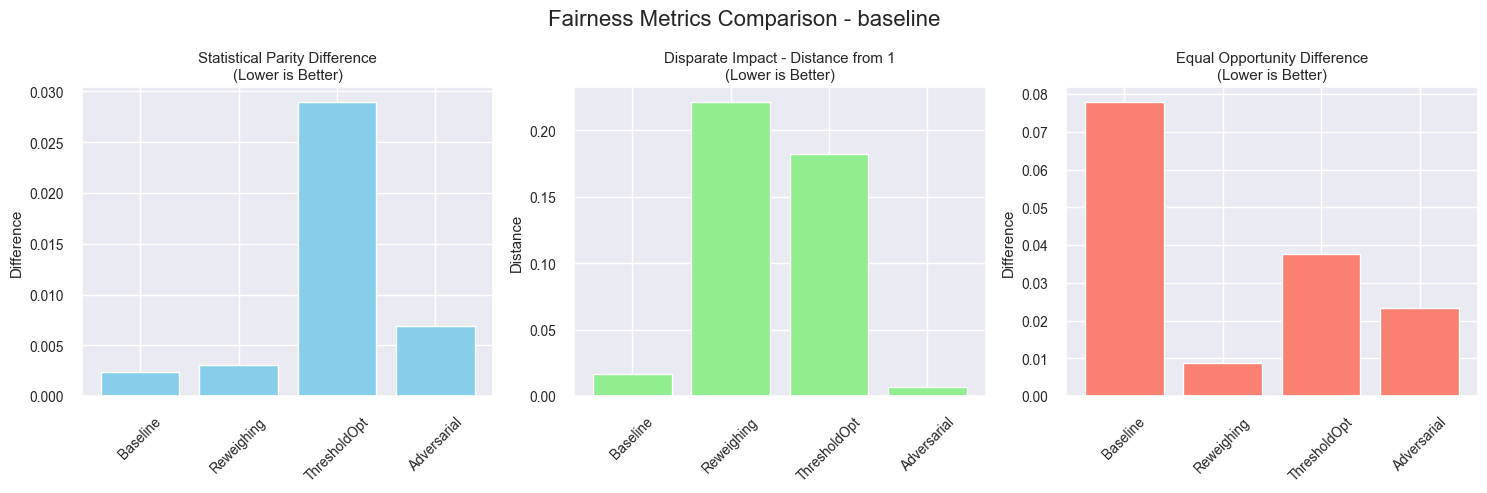


Comparison of all methods:
         Method  Statistical Parity Diff  Disparate Impact Ratio  \
0      Baseline                   0.0024                  0.9832   
1    Reweighing                   0.0030                  0.7785   
2  ThresholdOpt                   0.0290                  0.8177   
3   Adversarial                   0.0070                  0.9929   

   Equal Opportunity Diff  Accuracy  F1 Score  
0                  0.0779    0.8202    0.0745  
1                  0.0088    0.9379    0.0276  
2                  0.0376    0.8190    0.0773  
3                  0.0233    0.0702    0.0979  

BIAS ANALYSIS FOR HIGH_BIAS

Preparing dataset: high_bias
Training set: (13197, 10), Test set: (5656, 10)
Positive rate: 0.0493

Training baseline model
Baseline model performance:
Accuracy: 0.8271
Precision: 0.0431
Recall: 0.1183
F1 Score: 0.0632

Baseline fairness metrics:
statistical_parity_difference: 0.0148
disparate_impact_ratio: 0.8958
equal_opportunity_difference: 0.0156

Trainin

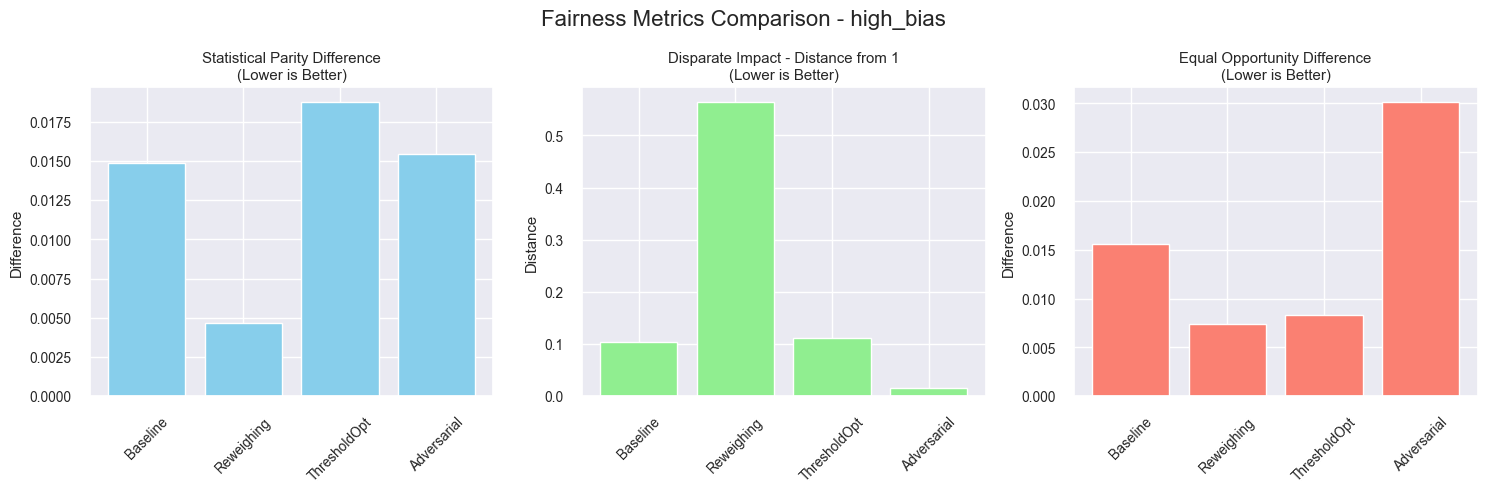


Comparison of all methods:
         Method  Statistical Parity Diff  Disparate Impact Ratio  \
0      Baseline                   0.0148                  0.8958   
1    Reweighing                   0.0047                  0.4357   
2  ThresholdOpt                   0.0188                  0.8882   
3   Adversarial                   0.0154                  0.9843   

   Equal Opportunity Diff  Accuracy  F1 Score  
0                  0.0156    0.8271    0.0632  
1                  0.0074    0.9450    0.0064  
2                  0.0083    0.8083    0.0782  
3                  0.0301    0.0736    0.0937  

BIAS ANALYSIS FOR FAIRJOBS

Preparing dataset: fairjobs
Training set: (750558, 17), Test set: (321668, 17)
Positive rate: 0.0070

Training baseline model
Baseline model performance:
Accuracy: 0.9924
Precision: 0.0806
Recall: 0.0089
F1 Score: 0.0160

Baseline fairness metrics:
statistical_parity_difference: 0.0003
disparate_impact_ratio: 0.6997
equal_opportunity_difference: 0.0013

Traini

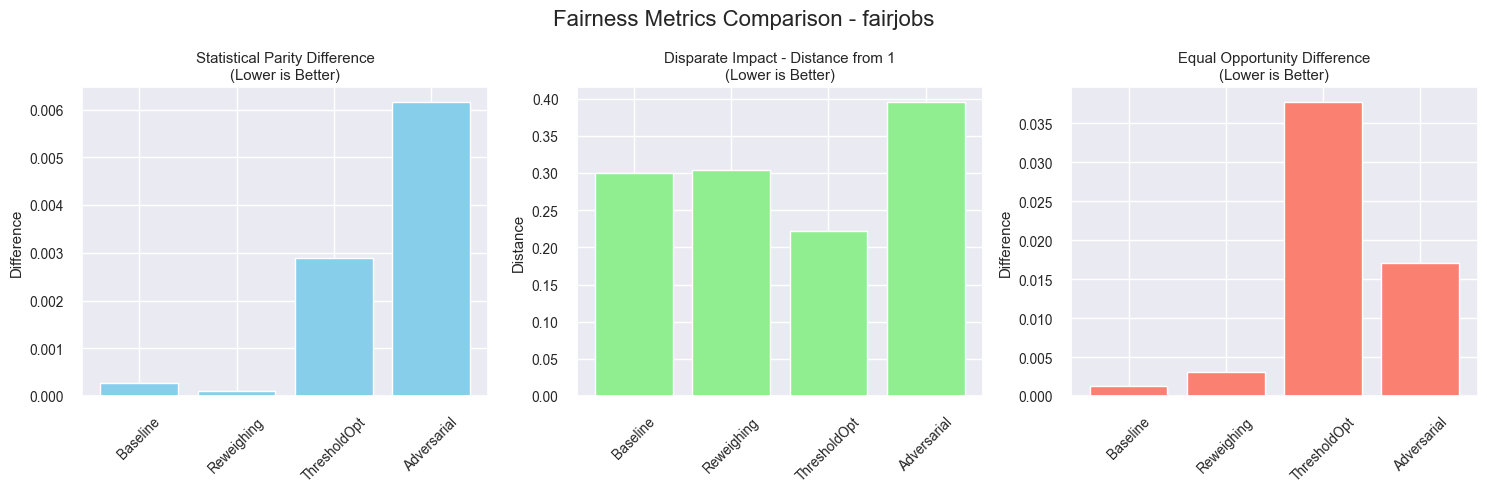


Comparison of all methods:
         Method  Statistical Parity Diff  Disparate Impact Ratio  \
0      Baseline                   0.0003                  0.6997   
1    Reweighing                   0.0001                  0.6960   
2  ThresholdOpt                   0.0029                  0.7779   
3   Adversarial                   0.0062                  0.6043   

   Equal Opportunity Diff  Accuracy  F1 Score  
0                  0.0013    0.9924    0.0160  
1                  0.0030    0.9928    0.0170  
2                  0.0377    0.9829    0.0767  
3                  0.0170    0.9820    0.0760  

CROSS-DATASET COMPARISON

Cross-dataset comparison of all methods:
         Method  Statistical Parity Diff  Disparate Impact Ratio  \
0      Baseline                   0.0024                  0.9832   
1    Reweighing                   0.0030                  0.7785   
2  ThresholdOpt                   0.0290                  0.8177   
3   Adversarial                   0.0070           

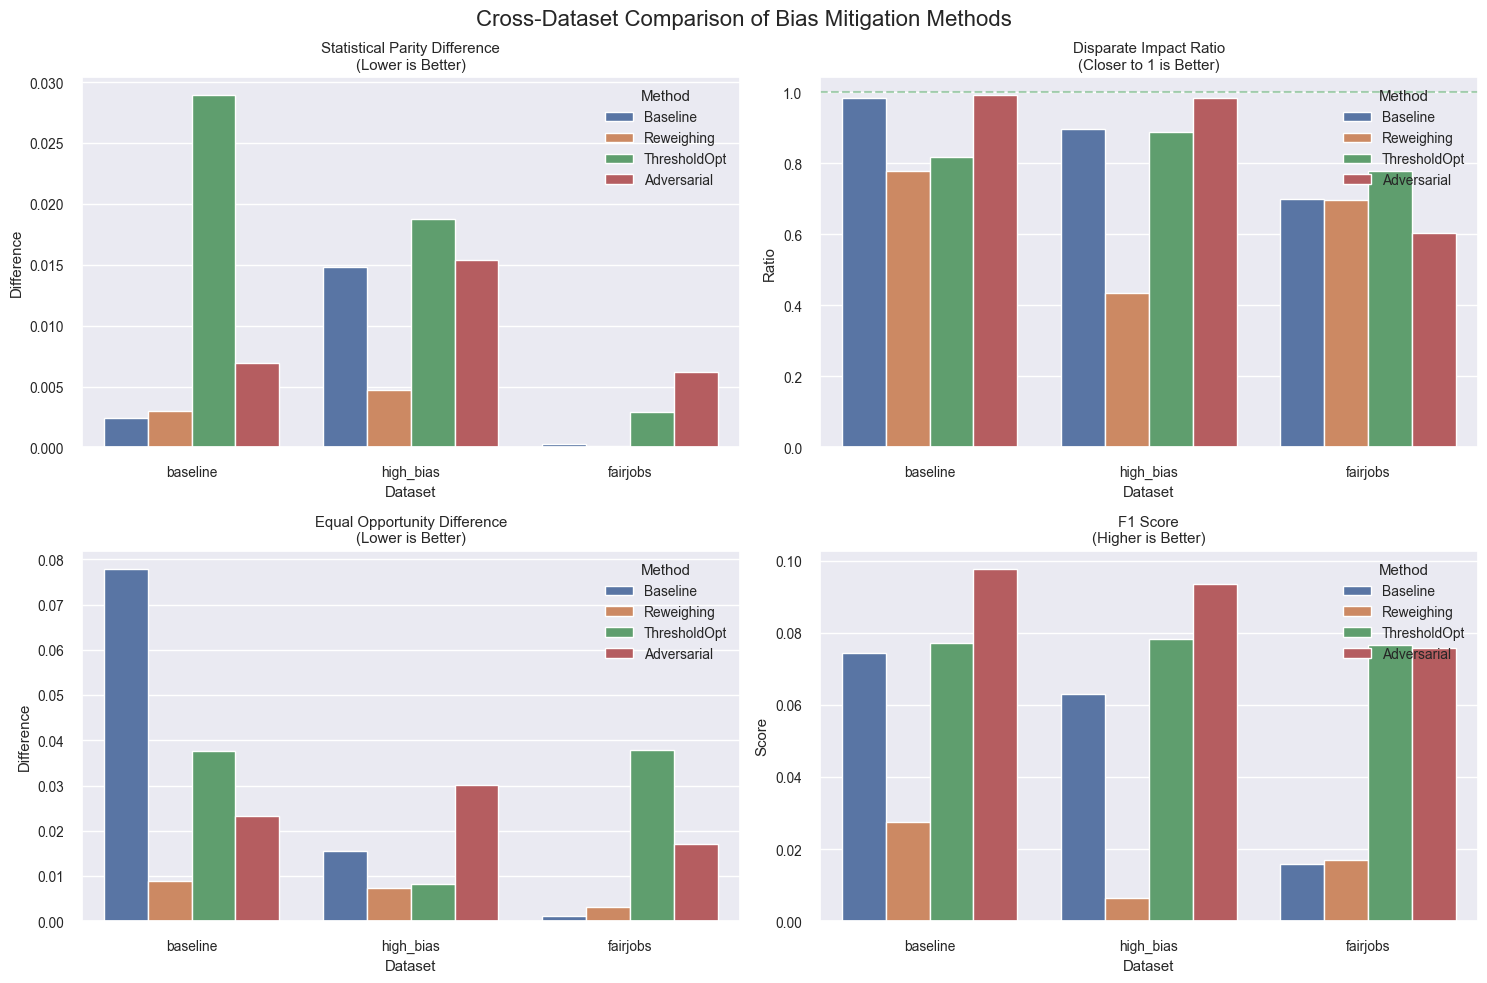


Analysis complete!


In [82]:
if __name__ == "__main__":
    # Define datasets to analyze
    datasets_to_analyze = ['baseline', 'high_bias', 'fairjobs']
    
    # Run the analysis
    results = run_debiasing_analysis(datasets_to_analyze)